## Import required libraries

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

## Input Data

In [2]:
l8_scores = gpd.read_file("../../resources/macro-loc-model-deployment/scored_output.geojson").drop(['index','prop_rail','prop_water','preds'], axis=1)
s2_scores = gpd.read_file("../../resources/macro-loc-model-deployment/s2_scored_output.geojson").drop(['scene_cloud_pnt', 'scene_group', 'max_cloud_cover', 'index','prop_rail','prop_water','preds'], axis=1)
proximity_scores = gpd.read_file("../../resources/macro-loc-model-deployment/macroloc_cement_steel_CHN_10_correct.shp")

In [3]:
len(proximity_scores)

50899

In [4]:
proximity_scores.head()

,index,length_w_x,length_r,length_w_y,length,Count_pnt,prop_rail,prop_water,prop_road,preds,geometry
0,141,0.279693,0.0,0.279693,0.0,0.0,0.0,0.000008,0.0,0.001532,"POLYGON ((73.25418 39.39812, 73.35418 39.39812..."
1,494,0.226492,0.0,0.226492,0.0,0.0,0.0,0.000007,0.0,0.001474,"POLYGON ((73.35418 39.39812, 73.45418 39.39812..."
2,847,0.111172,0.0,0.111172,0.0,0.0,0.0,0.000003,0.0,0.001350,"POLYGON ((73.45418 39.39812, 73.55418 39.39812..."
3,1200,0.121639,0.0,0.121639,0.0,0.0,0.0,0.000004,0.0,0.001361,"POLYGON ((73.55418 39.39812, 73.65418 39.39812..."
4,1553,0.113916,0.0,0.113916,0.0,0.0,0.0,0.000003,0.0,0.001353,"POLYGON ((73.65418 39.39812, 73.75418 39.39812..."


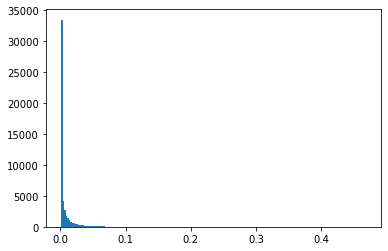

In [5]:
plt.hist(proximity_scores.preds, bins=200)
plt.show()

In [6]:
proximity_scores.describe()

,index,length_w_x,length_r,length_w_y,length,Count_pnt,prop_rail,prop_water,prop_road,preds
count,50899.000000,50899.000000,50899.000000,50899.000000,50899.000000,50899.000000,50899.000000,50899.000000,50899.000000,50899.000000
mean,119863.666732,0.674617,0.048289,0.674617,0.165750,0.011670,0.000020,0.000020,0.000020,0.007860
std,46694.928373,1.678124,0.291476,1.678124,0.525718,0.121799,0.000062,0.000049,0.000119,0.017823
min,141.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001230
25%,91990.500000,0.044169,0.000000,0.044169,0.000000,0.000000,0.000000,0.000001,0.000000,0.001460
50%,127773.000000,0.254719,0.000000,0.254719,0.000000,0.000000,0.000000,0.000007,0.000000,0.002057
75%,154470.500000,0.681579,0.002867,0.681579,0.073802,0.000000,0.000009,0.000020,0.000001,0.006280
max,217146.000000,94.868545,13.897527,94.868545,14.455807,4.000000,0.001713,0.002763,0.005654,0.468388


# CEMENT

In [54]:
# known cement plants
l8_cement = l8_scores[l8_scores.cement_uid.notnull()]
s2_cement = s2_scores[s2_scores.cement_uid.notnull()]

# join s2 and l8 geodataframes
cement_gdf = gpd.sjoin(s2_cement, l8_cement, how='left', op='intersects')

# group by s2 chips and take average of l8 score
cement_agg = cement_gdf.groupby(['tile_id_left','year_left','cement_prob_left','cement_uid_left']).agg({'cement_prob_right':'mean'}).reset_index()

# convert aggregated dataframe to geodataframe
cement_agg = pd.merge(cement_agg, cement_gdf[['tile_id_left','year_left','geometry']].drop_duplicates(), on=['tile_id_left','year_left'])
cement_agg.columns = ['tile_id','year','cement_prob_s2','cement_uid','cement_prob_l8','geometry']
cement_agg = gpd.GeoDataFrame(cement_agg, geometry='geometry')

# join s2/l8 geodataframe to proximity geodataframe
cement_gdf = gpd.sjoin(cement_agg, proximity_scores[['preds', 'geometry']], how='left', op='intersects')

# group by s2 chips and take average of proximity score
cement_gdf = cement_gdf.groupby(['tile_id','year','cement_prob_s2','cement_uid','cement_prob_l8']).agg({'preds':'mean'}).reset_index()
cement_gdf.columns = ['tile_id','year','cement_prob_s2','cement_uid','cement_prob_l8','cement_prob_proximity']

In [64]:
cement_gdf.head()

,tile_id,year,cement_prob_s2,cement_uid,cement_prob_l8,cement_prob_proximity
0,MGRS-44TPM-0294,2020,0.495042,CHN1079,0.920679,0.007288
1,MGRS-45TVG-0022,2020,0.155544,CHN0685,0.644753,0.020671
2,MGRS-45TWJ-0287,2020,0.615682,CHN0687,0.487513,0.028413
3,MGRS-45TWJ-0409,2020,0.100570,CHN0691,0.560330,0.033579
4,MGRS-46TEN-0208,2020,0.131714,CHN0684,0.429390,0.017827


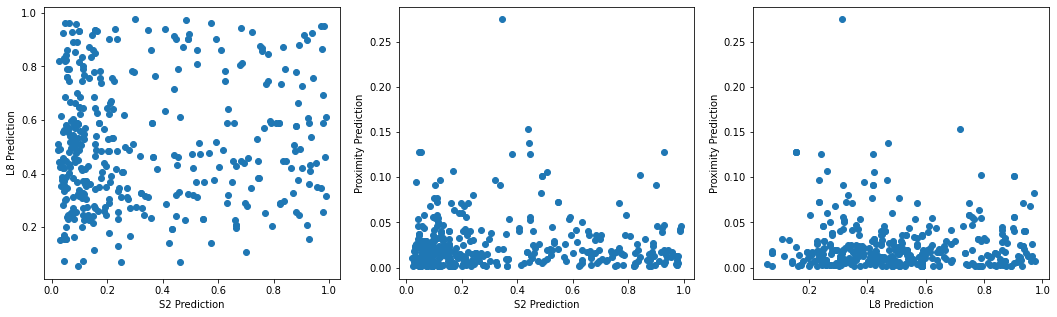

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax1.scatter(cement_gdf.cement_prob_s2.values, cement_gdf.cement_prob_l8.values)
ax1.set_xlabel('S2 Prediction')
ax1.set_ylabel('L8 Prediction')

ax2.scatter(cement_gdf.cement_prob_s2.values, cement_gdf.cement_prob_proximity.values)
ax2.set_xlabel('S2 Prediction')
ax2.set_ylabel('Proximity Prediction')

ax3.scatter(cement_gdf.cement_prob_l8.values, cement_gdf.cement_prob_proximity.values)
ax3.set_xlabel('L8 Prediction')
ax3.set_ylabel('Proximity Prediction')

plt.show()

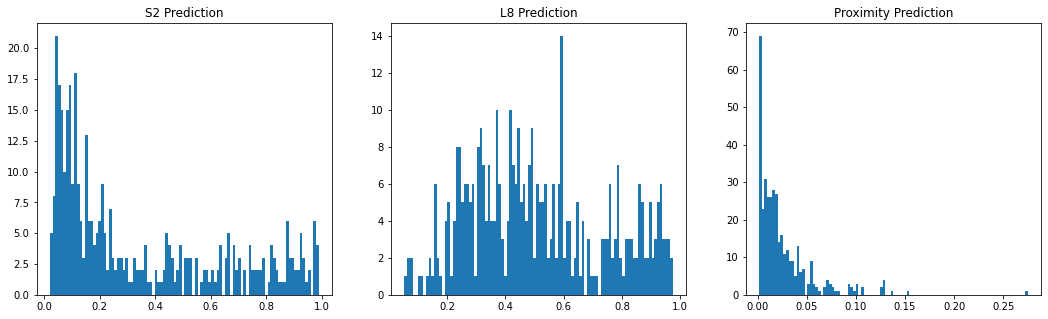

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax1.hist(cement_gdf.cement_prob_s2.values, bins=100)
ax1.set_title('S2 Prediction')

ax2.hist(cement_gdf.cement_prob_l8.values, bins=100)
ax2.set_title('L8 Prediction')

ax3.hist(cement_gdf.cement_prob_proximity.values, bins=100)
ax3.set_title('Proximity Prediction')

plt.show()

In [65]:
cement_gdf['average_prob'] = (cement_gdf['cement_prob_s2'] + cement_gdf['cement_prob_l8'] + cement_gdf['cement_prob_proximity']) / 3
cement_gdf['max_prob']  = cement_gdf[["cement_prob_s2", "cement_prob_l8", "cement_prob_proximity"]].max(axis=1)

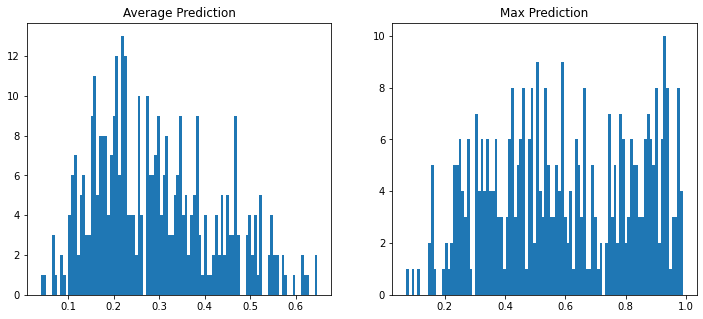

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax1.hist(cement_gdf.average_prob.values, bins=100)
ax1.set_title('Average Prediction')

ax2.hist(cement_gdf.max_prob.values, bins=100)
ax2.set_title('Max Prediction')

plt.show()

# STEEL

In [67]:
# known steel plants
l8_steel = l8_scores[l8_scores.steel_uid.notnull()]
s2_steel = s2_scores[s2_scores.steel_uid.notnull()]

# join s2 and l8 geodataframes
steel_gdf = gpd.sjoin(s2_steel, l8_steel, how='left', op='intersects')

# group by s2 chips and take average of l8 score
steel_agg = steel_gdf.groupby(['tile_id_left','year_left','steel_prob_left','steel_uid_left']).agg({'steel_prob_right':'mean'}).reset_index()

# convert aggregated dataframe to geodataframe
steel_agg = pd.merge(steel_agg, steel_gdf[['tile_id_left','year_left','geometry']].drop_duplicates(), on=['tile_id_left','year_left'])
steel_agg.columns = ['tile_id','year','steel_prob_s2','steel_uid','steel_prob_l8','geometry']
steel_agg = gpd.GeoDataFrame(steel_agg, geometry='geometry')

# join s2/l8 geodataframe to proximity geodataframe
steel_gdf = gpd.sjoin(steel_agg, proximity_scores[['preds', 'geometry']], how='left', op='intersects')

# group by s2 chips and take average of proximity score
steel_gdf = steel_gdf.groupby(['tile_id','year','steel_prob_s2','steel_uid','steel_prob_l8']).agg({'preds':'mean'}).reset_index()
steel_gdf.columns = ['tile_id','year','steel_prob_s2','steel_uid','steel_prob_l8','steel_prob_proximity']


In [68]:
steel_gdf.head()

,tile_id,year,steel_prob_s2,steel_uid,steel_prob_l8,steel_prob_proximity
0,MGRS-45TWJ-0338,2020,0.092780,CHN0014,0.524710,0.109414
1,MGRS-47RQK-0384,2020,0.872235,CHN0075,0.749981,0.072369
2,MGRS-47RRH-0321,2020,0.794473,CHN0072,0.691097,0.031700
3,MGRS-47RRH-0393,2020,0.117894,CHN0071,0.868268,0.040439
4,MGRS-47RRH-0468,2020,0.889687,CHN0187,0.647188,0.074939


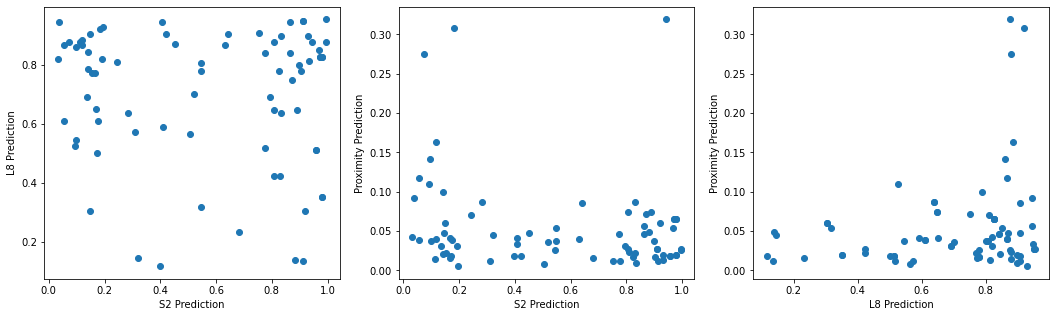

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax1.scatter(steel_gdf.steel_prob_s2.values, steel_gdf.steel_prob_l8.values)
ax1.set_xlabel('S2 Prediction')
ax1.set_ylabel('L8 Prediction')

ax2.scatter(steel_gdf.steel_prob_s2.values, steel_gdf.steel_prob_proximity.values)
ax2.set_xlabel('S2 Prediction')
ax2.set_ylabel('Proximity Prediction')

ax3.scatter(steel_gdf.steel_prob_l8.values, steel_gdf.steel_prob_proximity.values)
ax3.set_xlabel('L8 Prediction')
ax3.set_ylabel('Proximity Prediction')

plt.show()

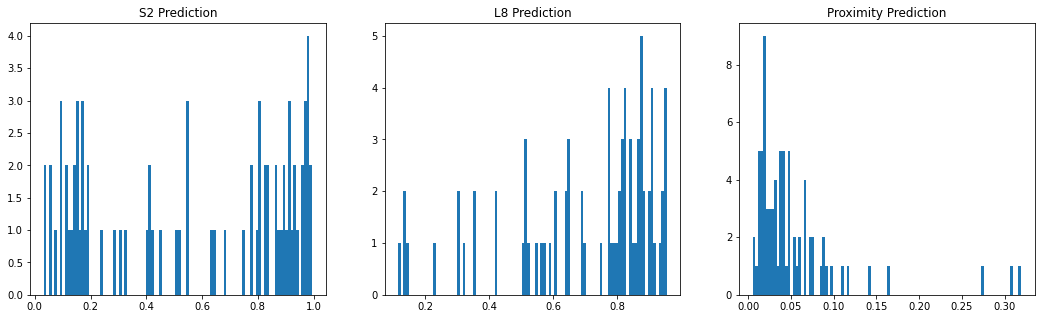

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax1.hist(steel_gdf.steel_prob_s2.values, bins=100)
ax1.set_title('S2 Prediction')

ax2.hist(steel_gdf.steel_prob_l8.values, bins=100)
ax2.set_title('L8 Prediction')

ax3.hist(steel_gdf.steel_prob_proximity.values, bins=100)
ax3.set_title('Proximity Prediction')

plt.show()

In [71]:
steel_gdf['average_prob'] = (steel_gdf['steel_prob_s2'] + steel_gdf['steel_prob_l8'] + steel_gdf['steel_prob_proximity']) / 3
steel_gdf['max_prob']  = steel_gdf[["steel_prob_s2", "steel_prob_l8", "steel_prob_proximity"]].max(axis=1)

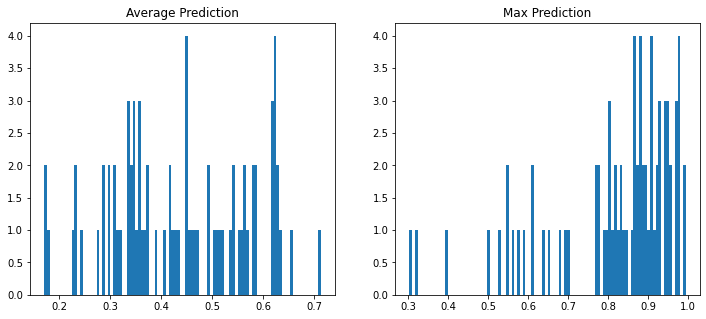

In [72]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax1.hist(steel_gdf.average_prob.values, bins=100)
ax1.set_title('Average Prediction')

ax2.hist(steel_gdf.max_prob.values, bins=100)
ax2.set_title('Max Prediction')

plt.show()